<a href="https://colab.research.google.com/github/EliasSf73/test_/blob/master/BCS441_CodingSession.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## BCS441 Coding Session 1: medical image diagnosis challenge

* TA: DoHyoung Lee, Sugun Yoon
* Please send questions about session 1 to bjj2931@kaist.ac.kr or sugunok@kaist.ac.kr.
* This code works itself, but it is not optimized at all.

### 1. Load packages

In [1]:
!pip install opencv-python


In [2]:
!pip install opencv-python  # Installing the opencv-python package to preprocess images

import numpy as np
import random
import collections
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imutils


In [3]:
# If you use google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Set hyperparameters
* About batch size & epoch
    * https://machine-learning.paperspace.com/wiki/epoch#:~:text=The%20number%20of%20iterations%20is,to%20complete%20a%20single%20epoch.
* **Other sections of this ipynb file define other hyperparameters. You can freely modify them.**


In [4]:
batch_size=400   #800
Epoch =10        #100
Learning_rate=0.00015  #0.1


### 3. Load and preprocess the dataset

* Original Dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data
* 4 classes: Glioma(신경교종), Meningioma(수막종), No tumor, Pituitary(뇌하수체)
* Each image has different size, so preprocessing is required to find the largest contour in a given image, and to find a rectangular region that is contiguous to that contour.

In [5]:
import os
import cv2
import imutils

def crop_img(img):
    # find the extreme points on the image and crops the rectangular out of them
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1] # change color from RGB to grayscale and binarize 0 or 255
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img

# Change file_path to a writable directory
file_path= "/content/drive/MyDrive/BCS441_CodingSession1_data/"  # Set to a relative path or writable directory
training = os.path.join(file_path, "Training")
testing = os.path.join(file_path, "Testing")
training_dir = os.listdir(training)
testing_dir = os.listdir(testing)
IMG_SIZE = 128

for dir in training_dir:
    save_path = os.path.join(file_path, 'Training', dir)
    path = os.path.join(training, dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path, img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(os.path.join(save_path, img), new_img)

for dir in testing_dir:
    save_path = os.path.join(file_path, 'Testing', dir)
    path = os.path.join(testing, dir)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = cv2.imread(os.path.join(path, img))
        new_img = crop_img(image)
        new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        cv2.imwrite(os.path.join(save_path, img), new_img)


In [6]:
file_path = "/content/drive/MyDrive/BCS441_CodingSession1_data/"  # You must change file_path

training_data=[]
test_data=[]
test_label = []

labels = ['glioma/', 'meningioma/', 'notumor/', 'pituitary/']

# to make label to one-hot vector ex) notumor -> [0, 0, 1, 0]
def one_hot_encoding(index, num_classes):
    one_hot = np.zeros(num_classes)
    one_hot[index] = 1
    return one_hot

for index, label in enumerate(labels):
    path = os.path.join(file_path + "Training/" + label)
    print(path)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = Image.open(path + img)
        image=np.array(image)/255
        image = image[np.newaxis, :, :]
        training_data.append([image, one_hot_encoding(index, len(labels))])

    path = os.path.join(file_path + "Testing/" + label)
    print(path)
    image_dir = os.listdir(path)
    for img in image_dir:
        image = Image.open(path + img)
        image=np.array(image)/255
        image = image[np.newaxis, :, :]
        test_data.append(image)
        test_label.append(one_hot_encoding(index, len(labels)))
test_label = torch.Tensor(test_label)

/content/drive/MyDrive/BCS441_CodingSession1_data/Training/glioma/
/content/drive/MyDrive/BCS441_CodingSession1_data/Testing/glioma/
/content/drive/MyDrive/BCS441_CodingSession1_data/Training/meningioma/
/content/drive/MyDrive/BCS441_CodingSession1_data/Testing/meningioma/
/content/drive/MyDrive/BCS441_CodingSession1_data/Training/notumor/
/content/drive/MyDrive/BCS441_CodingSession1_data/Testing/notumor/
/content/drive/MyDrive/BCS441_CodingSession1_data/Training/pituitary/
/content/drive/MyDrive/BCS441_CodingSession1_data/Testing/pituitary/


<ipython-input-6-f1ba44f84536>:34: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  test_label = torch.Tensor(test_label)


### 4. Separate the dataset (training set & validation set)

* The size of the validation set is a hyperparameter. (9:1 ratio for training:validation)

In [7]:
random.shuffle(training_data)
selected_training_data=training_data[:round(0.9 * len(training_data))]
validation_data=training_data[round(0.9 * len(training_data)):]

print(len(selected_training_data)) # training set size
print(len(validation_data)) # validation set size

5141
571


### 5. Define functions: batch sampling & validation data extraction



In [8]:
def batch_sampling (num):
    global selected_training_data

    if num==0:
        random.shuffle(selected_training_data)

    x_size=0
    train_x=[]
    train_y=[]
    for i in range(batch_size):
        try:
            train_x.append(selected_training_data[num*batch_size+i][0])
            train_y.append(selected_training_data[num*batch_size+i][1])
            x_size+=1
        except:
            break

    return torch.from_numpy(np.array(train_x)).float(), torch.from_numpy(np.array(train_y)).long(), x_size

def extract_validation_data ():
    global validation_data
    x_size = 0
    val_x=[]
    val_y=[]
    for i in range(len(validation_data)):
        val_x.append(validation_data[i][0])
        val_y.append(validation_data[i][1])
        x_size += 1
    return torch.from_numpy(np.array(val_x)).float(), torch.from_numpy(np.array(val_y)).long(), x_size


### 6. Define a neural network

* You can freely modify hyperparameters in the below part (number of layers, number of units, size of the kernel, etc.).
* You don't have to use a CNN. Try any other models if you want.
* For more details about the network components, check https://pytorch.org/docs/stable/index.html

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 5,stride = 1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 4, kernel_size = 3,stride = 1, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 4, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 4)
        self.softmax=nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 32 * 32 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return self.softmax(x)

net = Net() # make an instance
print(net) # check the architecture
print(net(torch.randn(10,1,128,128))) # see the network works correctly with an arbitrary input

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)
tensor([[0.2830, 0.1620, 0.3440, 0.2110],
        [0.2825, 0.1613, 0.3454, 0.2108],
        [0.2800, 0.1607, 0.3460, 0.2133],
        [0.2786, 0.1592, 0.3492, 0.2129],
        [0.2901, 0.1613, 0.3325, 0.2161],
        [0.2897, 0.1617, 0.3324, 0.2161],
        [0.2829, 0.1606, 0.3433, 0.2133],
        [0.2913, 0.1633, 0.3391, 0.2062],
        [0.2813, 0.1607, 0.3476, 0.2104],
        [0.2861, 0.1610, 0.3409, 0.2120]], grad_fn=<SoftmaxBackward0>)


### 7. Define a loss function and optimizer

In [10]:
def criterion(y_pred, y_true):
    y_pred = torch.clamp(y_pred, 1e-9, 1 - 1e-9)
    return -(y_true * torch.log(y_pred)).sum(dim=1).mean()

optimizer = optim.Adam(net.parameters(), lr=Learning_rate)
optimizer.state = collections.defaultdict(dict) # network initialization

### 8. Train the network and print the train/validation accuracy output

In [11]:
batch_number=int((len(selected_training_data)-0.5)/batch_size)+1
train_loss_epoch = []
val_loss_epoch = []
train_acc_epoch = []
val_acc_epoch = []
for epoch in range(Epoch):
    net.train()
    for batch in range(batch_number):
        train_x, train_y, x_size = batch_sampling(batch)
        optimizer.zero_grad()  # Gradient Reset
        output = net(train_x)
        loss = criterion(output, train_y)
        loss.backward()  # Back propagation
        optimizer.step()

    with torch.no_grad():
        net.eval()
        print("Epoch ", epoch)
        training_loss=0
        training_accuracy=0
        for batch in range(batch_number):
            train_x, train_y, x_size = batch_sampling(batch)
            output = net(train_x)
            training_loss += x_size*criterion(output, train_y).item()
            _, predicted = torch.max(output.data, 1)
            _, label_index = torch.max(train_y, 1)
            training_accuracy+=(predicted == label_index).sum().item()

        training_accuracy=training_accuracy/len(selected_training_data)
        training_loss=training_loss/len(selected_training_data)
        train_acc_epoch.append(training_accuracy)
        train_loss_epoch.append(training_loss)

        print("Training loss (average) :", training_loss)
        print("Training accuracy       :", training_accuracy * 100,"%")

        validation_loss=0
        validation_accuracy=0
        val_x, val_y, x_size=extract_validation_data()
        output = net(val_x)

        validation_loss += x_size * criterion(output, val_y).item()

        _, predicted_v = torch.max(output.data, 1)
        _, label_index_v = torch.max(val_y, 1)
        validation_accuracy += (predicted_v == label_index_v).sum().item()
        validation_accuracy=validation_accuracy/len(validation_data)
        validation_loss = validation_loss / len(validation_data)
        val_acc_epoch.append(validation_accuracy)
        val_loss_epoch.append(validation_loss)

        print("Validation loss (average) :", validation_loss)
        print("Validation accuracy       :", validation_accuracy * 100, "%")

Epoch  0
Training loss (average) : 1.3814697388521175
Training accuracy       : 27.990663295078775 %
Validation loss (average) : 1.3796602487564087
Validation accuracy       : 27.32049036777583 %
Epoch  1
Training loss (average) : 1.3443855522810961
Training accuracy       : 27.990663295078775 %
Validation loss (average) : 1.3425216674804688
Validation accuracy       : 27.32049036777583 %
Epoch  2
Training loss (average) : 1.2820649437810678
Training accuracy       : 33.028593658821244 %
Validation loss (average) : 1.2795523405075073
Validation accuracy       : 33.09982486865149 %
Epoch  3
Training loss (average) : 1.2061421200357691
Training accuracy       : 48.10348181287687 %
Validation loss (average) : 1.2032982110977173
Validation accuracy       : 48.51138353765324 %
Epoch  4
Training loss (average) : 1.1394025984266765
Training accuracy       : 50.74888154055631 %
Validation loss (average) : 1.1373064517974854
Validation accuracy       : 51.66374781085814 %
Epoch  5
Training loss

### 9. Plot learning curves

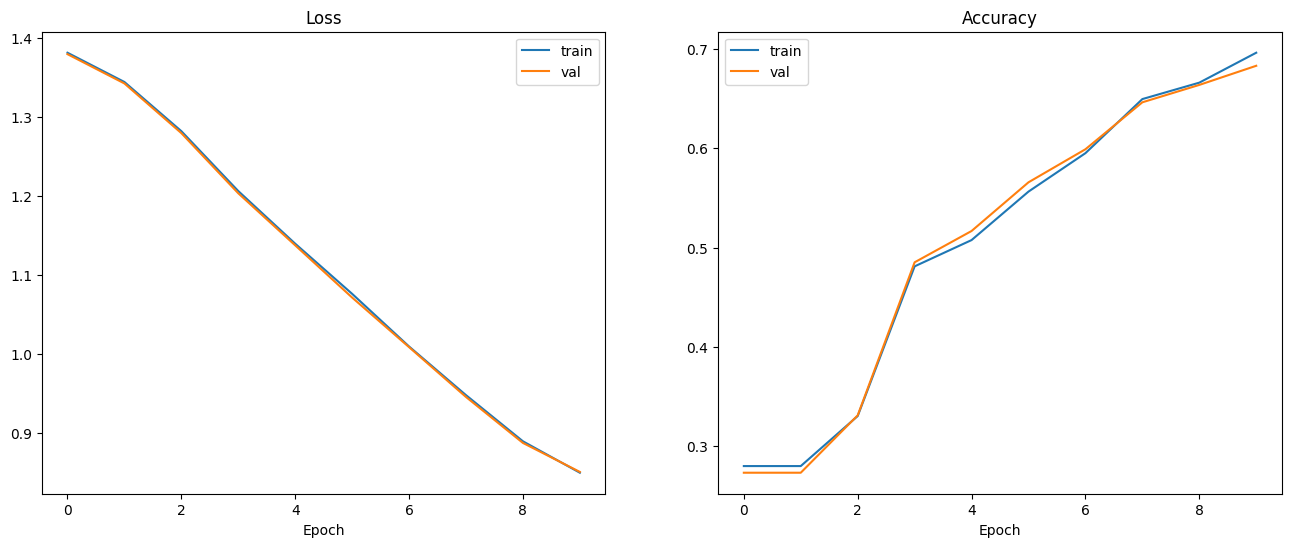

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].plot(train_loss_epoch, label = 'train')
axs[0].plot(val_loss_epoch, label = 'val')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

axs[1].plot(train_acc_epoch, label = 'train')
axs[1].plot(val_acc_epoch, label = 'val')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend()


### 10. Classify test dataset

In [13]:
output = net(torch.from_numpy(np.array(test_data)).float())
accuracy_list = [torch.equal(torch.argmax(output[i]), torch.argmax(test_label[i]))
          for i in range(test_label.size(0))]
accuracy = sum(accuracy_list) / len(accuracy_list)
print("Test accuracy       :", accuracy * 100, "%")

Test accuracy       : 62.92906178489702 %
